Lambda School Data Science

*Unit 2, Sprint 1, Module 3*

---

# Ridge Regression

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

- [ ] Use a subset of the data where `BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'` and the sale price was more than 100 thousand and less than 2 million.
- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Fit a ridge regression model with multiple features. Use the `normalize=True` parameter (or do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html) beforehand — use the scaler's `fit_transform` method with the train set, and the scaler's `transform` method with the test set)
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


## Stretch Goals

Don't worry, you aren't expected to do all these stretch goals! These are just ideas to consider and choose from.

- [ ] Add your own stretch goal(s) !
- [ ] Instead of `Ridge`, try `LinearRegression`. Depending on how many features you select, your errors will probably blow up! 💥
- [ ] Instead of `Ridge`, try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv(DATA_PATH+'condos/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [0]:
# BOROUGH is a numeric column, but arguably should be a categorical feature,
# so convert it from a number to a string
df['BOROUGH'] = df['BOROUGH'].astype(str)

In [0]:
# Reduce cardinality for NEIGHBORHOOD feature

# Get a list of the top 10 neighborhoods
top10 = df['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
df.loc[~df['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

In [21]:
print(df.shape)
df.head()

(23040, 21)


,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
0,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,716,1246,NaN,R4,"447 WEST 18TH STREET, PH12A",PH12A,10011.0,1.0,0.0,1.0,"10,733",1979.0,2007.0,2,R4,0,01/01/2019
1,1,OTHER,21 OFFICE BUILDINGS,4,812,68,NaN,O5,144 WEST 37TH STREET,NaN,10018.0,0.0,6.0,6.0,"2,962",15435.0,1920.0,4,O5,0,01/01/2019
2,1,OTHER,21 OFFICE BUILDINGS,4,839,69,NaN,O5,40 WEST 38TH STREET,NaN,10018.0,0.0,7.0,7.0,"2,074",11332.0,1930.0,4,O5,0,01/01/2019
3,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,592,1041,NaN,R4,"1 SHERIDAN SQUARE, 8C",8C,10014.0,1.0,0.0,1.0,0,500.0,0.0,2,R4,0,01/01/2019
4,1,UPPER EAST SIDE (59-79),15 CONDOS - 2-10 UNIT RESIDENTIAL,2C,1379,1402,NaN,R1,"20 EAST 65TH STREET, B",B,10065.0,1.0,0.0,1.0,0,6406.0,0.0,2,R1,0,01/01/2019


##Use a subset of the data where BUILDING_CLASS_CATEGORY == '01 ONE FAMILY DWELLINGS' and the sale price was more than 100 thousand and less than 2 million.

In [22]:
df_1f = df[df['BUILDING_CLASS_CATEGORY'] == '01 ONE FAMILY DWELLINGS']
df_1f = df_1f[df['SALE_PRICE'] > 100000]
df_1f = df_1f[df['SALE_PRICE'] < 2000000]
print(df_1f.shape)
df_1f.head()

(3151, 21)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
44,3,OTHER,01 ONE FAMILY DWELLINGS,1,5495,801,NaN,A9,4832 BAY PARKWAY,NaN,11230.0,1.0,0.0,1.0,"6,800",1325.0,1930.0,1,A9,550000,01/01/2019
61,4,OTHER,01 ONE FAMILY DWELLINGS,1,7918,72,NaN,A1,80-23 232ND STREET,NaN,11427.0,1.0,0.0,1.0,"4,000",2001.0,1940.0,1,A1,200000,01/01/2019
78,2,OTHER,01 ONE FAMILY DWELLINGS,1,4210,19,NaN,A1,1260 RHINELANDER AVE,NaN,10461.0,1.0,0.0,1.0,"3,500",2043.0,1925.0,1,A1,810000,01/02/2019
108,3,OTHER,01 ONE FAMILY DWELLINGS,1,5212,69,NaN,A1,469 E 25TH ST,NaN,11226.0,1.0,0.0,1.0,"4,000",2680.0,1899.0,1,A1,125000,01/02/2019
111,3,OTHER,01 ONE FAMILY DWELLINGS,1,7930,121,NaN,A5,5521 WHITTY LANE,NaN,11203.0,1.0,0.0,1.0,"1,710",1872.0,1940.0,1,A5,620000,01/02/2019


##Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.

In [23]:
df_1f.dtypes

BOROUGH                            object
NEIGHBORHOOD                       object
BUILDING_CLASS_CATEGORY            object
TAX_CLASS_AT_PRESENT               object
BLOCK                               int64
LOT                                 int64
EASE-MENT                         float64
BUILDING_CLASS_AT_PRESENT          object
ADDRESS                            object
APARTMENT_NUMBER                   object
ZIP_CODE                          float64
RESIDENTIAL_UNITS                 float64
COMMERCIAL_UNITS                  float64
TOTAL_UNITS                       float64
LAND_SQUARE_FEET                   object
GROSS_SQUARE_FEET                 float64
YEAR_BUILT                        float64
TAX_CLASS_AT_TIME_OF_SALE           int64
BUILDING_CLASS_AT_TIME_OF_SALE     object
SALE_PRICE                          int64
SALE_DATE                          object
dtype: object

In [24]:
#convert SALE_DATE to a date object type
df_1f['SALE_DATE'] = pd.to_datetime(df_1f['SALE_DATE'])
df_1f.dtypes

BOROUGH                                   object
NEIGHBORHOOD                              object
BUILDING_CLASS_CATEGORY                   object
TAX_CLASS_AT_PRESENT                      object
BLOCK                                      int64
LOT                                        int64
EASE-MENT                                float64
BUILDING_CLASS_AT_PRESENT                 object
ADDRESS                                   object
APARTMENT_NUMBER                          object
ZIP_CODE                                 float64
RESIDENTIAL_UNITS                        float64
COMMERCIAL_UNITS                         float64
TOTAL_UNITS                              float64
LAND_SQUARE_FEET                          object
GROSS_SQUARE_FEET                        float64
YEAR_BUILT                               float64
TAX_CLASS_AT_TIME_OF_SALE                  int64
BUILDING_CLASS_AT_TIME_OF_SALE            object
SALE_PRICE                                 int64
SALE_DATE           

In [25]:
df_1f['SALE_DATE'].head()

44    2019-01-01
61    2019-01-01
78    2019-01-02
108   2019-01-02
111   2019-01-02
Name: SALE_DATE, dtype: datetime64[ns]

In [26]:
df_1f['LAND_SQUARE_FEET'] = df_1f['LAND_SQUARE_FEET'].str.replace(',', '').astype(float)
df_1f['LAND_SQUARE_FEET'].dtype

dtype('float64')

In [27]:
# split the data by date
train = df_1f[df_1f['SALE_DATE'] < '2019-03-01']
test = df_1f[df_1f['SALE_DATE'] >= '2019-03-01']
print(df_1f.shape,train.shape,test.shape)

(3151, 21) (1708, 21) (1443, 21)


##Do one-hot encoding of categorical features.

In [28]:
df_1f.head(1)

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
44,3,OTHER,01 ONE FAMILY DWELLINGS,1,5495,801,NaN,A9,4832 BAY PARKWAY,NaN,11230.0,1.0,0.0,1.0,6800.0,1325.0,1930.0,1,A9,550000,2019-01-01


In [29]:
# look to see which features are high carnality
full_features = df_1f.columns
for i in full_features:
  print(df_1f[i].value_counts())
  print()


4    1580
5     738
3     537
2     293
1       3
Name: BOROUGH, dtype: int64

OTHER                 2990
FLUSHING-NORTH          97
FOREST HILLS            22
BOROUGH PARK            19
ASTORIA                 14
BEDFORD STUYVESANT       9
Name: NEIGHBORHOOD, dtype: int64

01 ONE FAMILY DWELLINGS    3151
Name: BUILDING_CLASS_CATEGORY, dtype: int64

1     3111
1D      40
Name: TAX_CLASS_AT_PRESENT, dtype: int64

16350    21
1272      7
5506      6
6022      6
5735      6
         ..
569       1
4667      1
5730      1
6720      1
6145      1
Name: BLOCK, Length: 2496, dtype: int64

20      58
19      56
1       53
31      47
40      46
        ..
556      1
554      1
488      1
484      1
1200     1
Name: LOT, Length: 332, dtype: int64

Series([], Name: EASE-MENT, dtype: int64)

A1    1185
A5     985
A2     491
A9     239
A0      85
S1      48
A3      43
A8      40
A4      16
A6      15
B2       2
S0       1
B3       1
Name: BUILDING_CLASS_AT_PRESENT, dtype: int64

22-40 93RD STREET  

In [33]:
# Exclude columns with high carnality.
target = 'SALE_PRICE'
high_carnality_or_redundant = ['EASE-MENT','BUILDING_CLASS_CATEGORY','BLOCK','LOT','ADDRESS','APARTMENT_NUMBER','ZIP_CODE','TAX_CLASS_AT_TIME_OF_SALE','SALE_DATE']
features = train.columns.drop([target] + high_carnality_or_redundant)

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]
print(X_train.shape,X_test.shape)

(1708, 11) (1443, 11)


In [34]:
# perform OneHotEncoding on the remaining columns
import category_encoders as ce

encoder = ce.OneHotEncoder(use_cat_names=True)
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

print(X_train.shape,X_test.shape)

(1708, 42) (1443, 42)


In [35]:
X_train.head(1)

,BOROUGH_3,BOROUGH_4,BOROUGH_2,BOROUGH_5,NEIGHBORHOOD_OTHER,NEIGHBORHOOD_FLUSHING-NORTH,NEIGHBORHOOD_BEDFORD STUYVESANT,NEIGHBORHOOD_FOREST HILLS,NEIGHBORHOOD_BOROUGH PARK,NEIGHBORHOOD_ASTORIA,TAX_CLASS_AT_PRESENT_1,TAX_CLASS_AT_PRESENT_1D,BUILDING_CLASS_AT_PRESENT_A9,BUILDING_CLASS_AT_PRESENT_A1,BUILDING_CLASS_AT_PRESENT_A5,BUILDING_CLASS_AT_PRESENT_A0,BUILDING_CLASS_AT_PRESENT_A2,BUILDING_CLASS_AT_PRESENT_A3,BUILDING_CLASS_AT_PRESENT_S1,BUILDING_CLASS_AT_PRESENT_A4,BUILDING_CLASS_AT_PRESENT_A6,BUILDING_CLASS_AT_PRESENT_A8,BUILDING_CLASS_AT_PRESENT_B2,BUILDING_CLASS_AT_PRESENT_S0,BUILDING_CLASS_AT_PRESENT_B3,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,BUILDING_CLASS_AT_TIME_OF_SALE_A9,BUILDING_CLASS_AT_TIME_OF_SALE_A1,BUILDING_CLASS_AT_TIME_OF_SALE_A5,BUILDING_CLASS_AT_TIME_OF_SALE_A0,BUILDING_CLASS_AT_TIME_OF_SALE_A2,BUILDING_CLASS_AT_TIME_OF_SALE_A3,BUILDING_CLASS_AT_TIME_OF_SALE_S1,BUILDING_CLASS_AT_TIME_OF_SALE_A4,BUILDING_CLASS_AT_TIME_OF_SALE_A6,BUILDING_CLASS_AT_TIME_OF_SALE_A8,BUILDING_CLASS_AT_TIME_OF_SALE_S0
44,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,1.0,6800.0,1325.0,1930.0,1,0,0,0,0,0,0,0,0,0,0


##Do feature selection with SelectKBest.

In [0]:
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.metrics import mean_absolute_error

In [55]:
# going to use SelectKBest to see the top 15 features as an abitrary number
selector = SelectKBest(score_func=f_regression,k=10)
X_train_selected = selector.fit_transform(X_train,y_train)
X_test_selected = selector.transform(X_test)
X_train_selected.shape

(1708, 10)

In [56]:
# see what features were selected
all_name = X_train.columns
selected_mask = selector.get_support()
selected_names = all_name[selected_mask]
unselected_names = all_name[~selected_mask]

print('Features Selected:')
for name in selected_names:
  print(name)
print()
print("Features Not Selected:")
for name in unselected_names:
  print(name)

Features Selected:
BOROUGH_3
BOROUGH_2
BOROUGH_5
NEIGHBORHOOD_OTHER
NEIGHBORHOOD_FLUSHING-NORTH
NEIGHBORHOOD_FOREST HILLS
BUILDING_CLASS_AT_PRESENT_A3
LAND_SQUARE_FEET
GROSS_SQUARE_FEET
BUILDING_CLASS_AT_TIME_OF_SALE_A3

Features Not Selected:
BOROUGH_4
NEIGHBORHOOD_BEDFORD STUYVESANT
NEIGHBORHOOD_BOROUGH PARK
NEIGHBORHOOD_ASTORIA
TAX_CLASS_AT_PRESENT_1
TAX_CLASS_AT_PRESENT_1D
BUILDING_CLASS_AT_PRESENT_A9
BUILDING_CLASS_AT_PRESENT_A1
BUILDING_CLASS_AT_PRESENT_A5
BUILDING_CLASS_AT_PRESENT_A0
BUILDING_CLASS_AT_PRESENT_A2
BUILDING_CLASS_AT_PRESENT_S1
BUILDING_CLASS_AT_PRESENT_A4
BUILDING_CLASS_AT_PRESENT_A6
BUILDING_CLASS_AT_PRESENT_A8
BUILDING_CLASS_AT_PRESENT_B2
BUILDING_CLASS_AT_PRESENT_S0
BUILDING_CLASS_AT_PRESENT_B3
RESIDENTIAL_UNITS
COMMERCIAL_UNITS
TOTAL_UNITS
YEAR_BUILT
BUILDING_CLASS_AT_TIME_OF_SALE_A9
BUILDING_CLASS_AT_TIME_OF_SALE_A1
BUILDING_CLASS_AT_TIME_OF_SALE_A5
BUILDING_CLASS_AT_TIME_OF_SALE_A0
BUILDING_CLASS_AT_TIME_OF_SALE_A2
BUILDING_CLASS_AT_TIME_OF_SALE_S1
BUILDING_C

##Fit a ridge regression model with multiple features. Use the normalize=True parameter (or do feature scaling beforehand — use the scaler's fit_transform method with the train set, and the scaler's transform method with the test set)

##And get mean absolute error for the test set.

In [0]:
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
%matplotlib inline

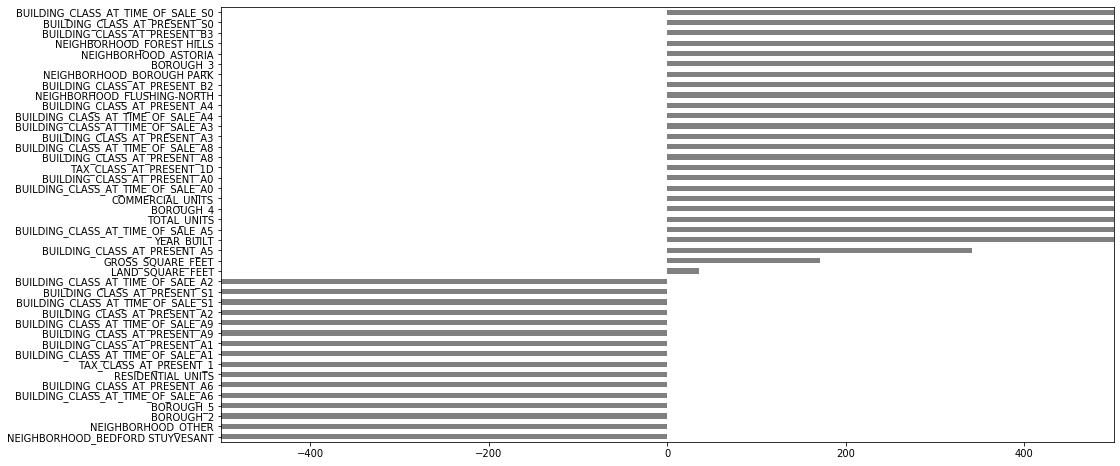

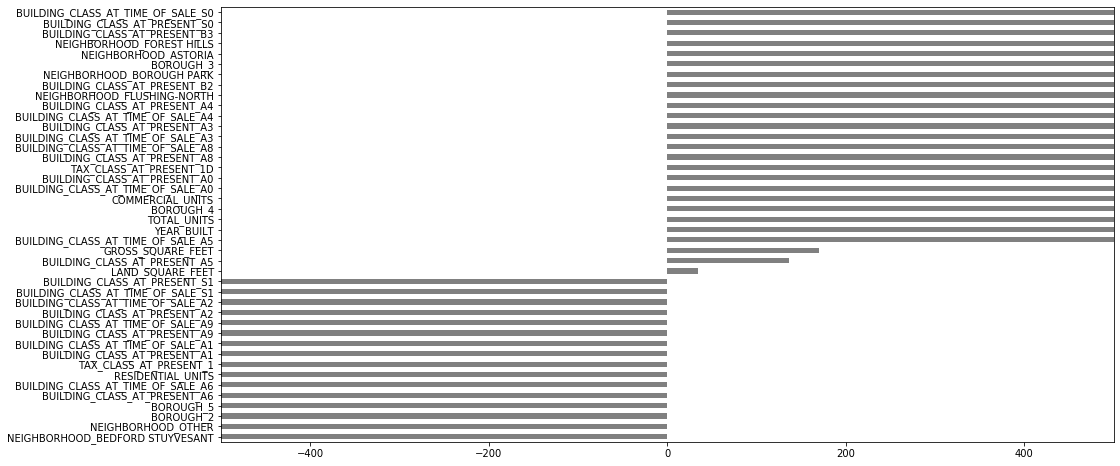

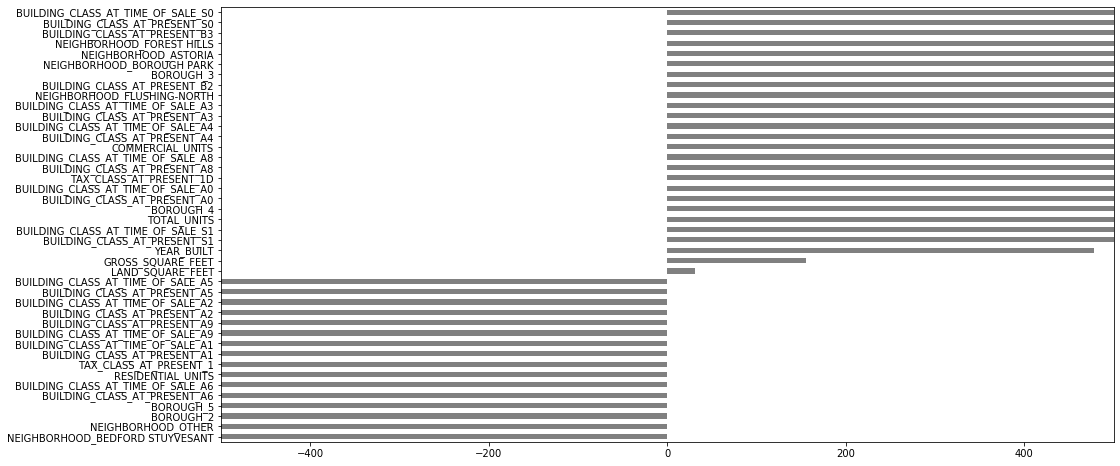

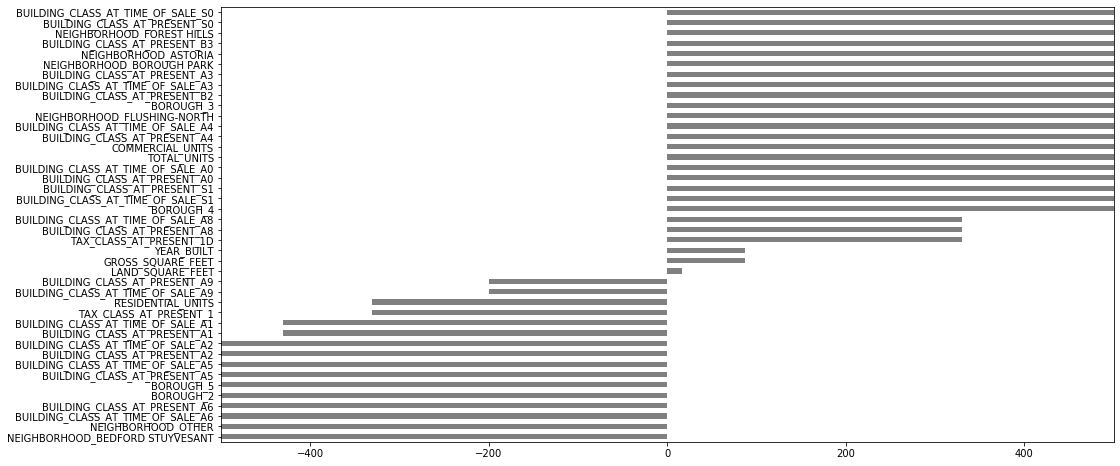

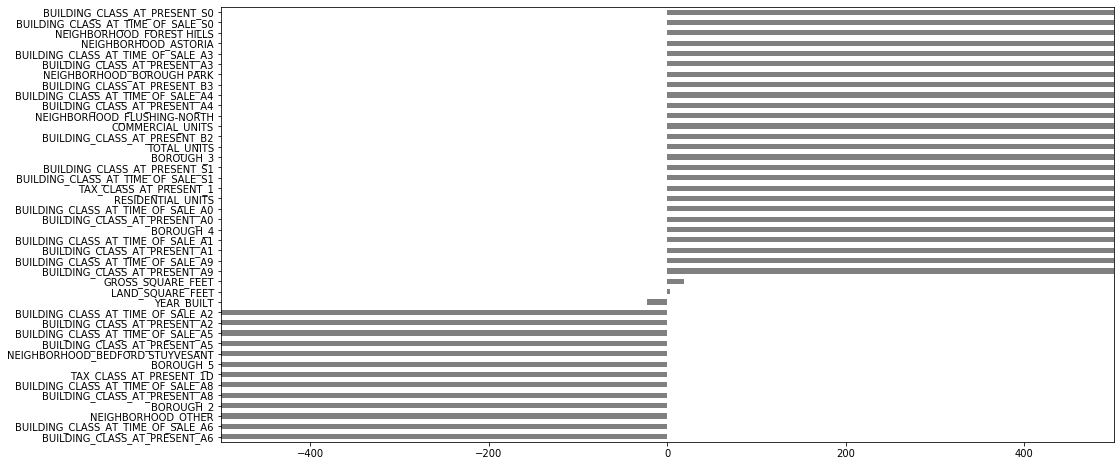

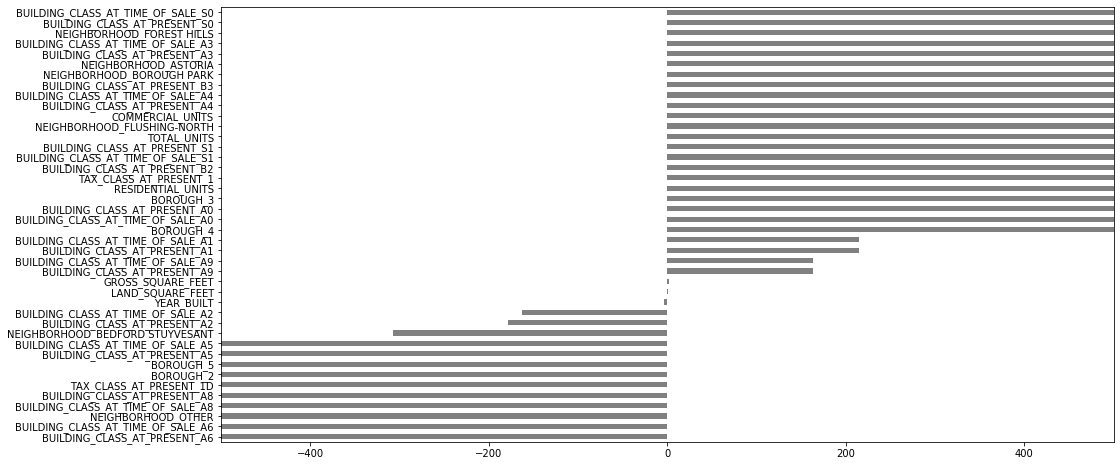

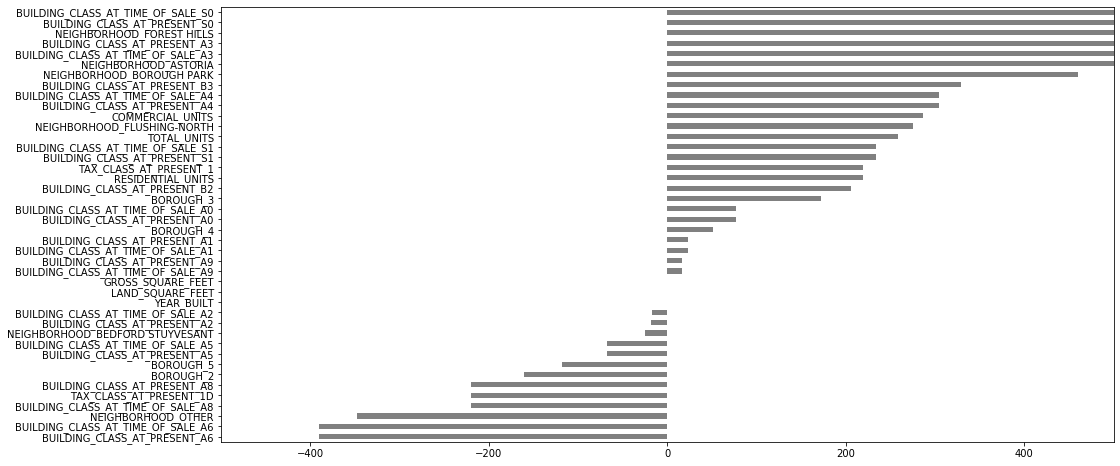

In [61]:
for alpha in [.001,.01,.1,1,10,100,1000]:
  # Fit Ridge Regression Model
  display(HTML(f'RidgeRegression with alpha={alpha}'))
  model = Ridge(alpha=alpha, normalize=True)
  model.fit(X_train,y_train)
  y_pred = model.predict(X_test)

  # Get Test MAE
  mae = mean_absolute_error(y_test,y_pred)
  display(HTML(f'Test Mean Absolute Error: ${mae:,.0f}'))

  #Plot coefficients
  coefficients = pd.Series(model.coef_,X_train.columns)
  plt.figure(figsize=(16,8))
  coefficients.sort_values().plot.barh(color='grey')
  plt.xlim(-500,500)
  plt.show()

##As always, commit your notebook to your fork of the GitHub repo.

#Stretch Goals

##Trying out the RidgeCV

In [0]:
alphas = [.001,.01,.1,1,10,100,1000]

In [64]:
from sklearn.linear_model import RidgeCV
ridge = RidgeCV(alphas=alphas, normalize=True)
ridge.fit(X_train, y_train)
ridge.alpha_

0.01

In [0]:
# by using this RidgeCV has determined that an alpha of .01 is the best fit
#   for this Ridge Regression

## Looking to see how many features is best using SelectKBest and Linear Regression

In [0]:
from sklearn.linear_model import LinearRegression

In [67]:
selector = SelectKBest(score_func=f_regression, k=15)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)
X_train_selected.shape

(1708, 15)

1features:
Test MAE: $186,730

2features:
Test MAE: $183,575

3features:
Test MAE: $175,173

4features:
Test MAE: $169,338

5features:
Test MAE: $169,044

6features:
Test MAE: $169,044

7features:
Test MAE: $167,543

8features:
Test MAE: $164,513

9features:
Test MAE: $163,926

10features:
Test MAE: $163,794

11features:
Test MAE: $163,795

12features:
Test MAE: $163,130

13features:
Test MAE: $164,491

14features:
Test MAE: $164,078

15features:
Test MAE: $163,695

16features:
Test MAE: $163,729

17features:
Test MAE: $163,729

18features:
Test MAE: $163,763

19features:
Test MAE: $163,622

20features:
Test MAE: $163,622

21features:
Test MAE: $163,622

22features:
Test MAE: $163,622

23features:
Test MAE: $163,644

24features:
Test MAE: $163,644

25features:
Test MAE: $163,545

26features:
Test MAE: $163,502

27features:
Test MAE: $163,477

28features:
Test MAE: $163,462

29features:
Test MAE: $163,241

30features:
Test MAE: $163,241

31features:
Test MAE: $163,015

32features:
Test 

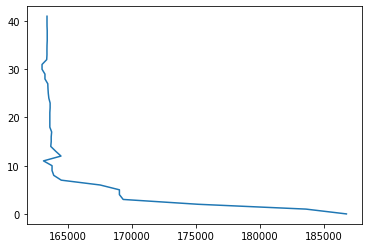

In [74]:
mylist = []
for k in range(1,len(X_train.columns)+1):
  print(f'{k}features:')

  selector = SelectKBest(score_func=f_regression,k=k)
  X_train_selected = selector.fit_transform(X_train,y_train)
  X_test_selected = selector.transform(X_test)
  X_train_selected.shape

  model = LinearRegression()
  model.fit(X_train_selected, y_train)
  y_pred = model.predict(X_test_selected)

  mae = mean_absolute_error(y_test,y_pred)
  mylist.append(mae)
  print(f'Test MAE: ${mae:,.0f}\n')

plt.plot(mylist, range(len(X_train.columns)));